# Recommendations Systems
## Course Project
**By Millis Sahar**

<br>

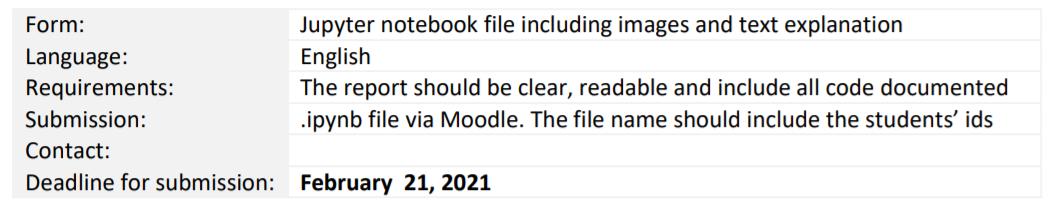

<br>

Each student will submit his\her own assignment.  

Submit your solution in the form of an Jupyter notebook file (with extension ipynb).   
Images of graphs or tables should be submitted as part of the notebook itself.   

The code used to answer the questions should be included, runnable and documented in the notebook.   
Python 3.6 or higher should be used.   

The goal of this project is to let you practice in a data scientist daily work by leveraging recommender
systems algorithms you learnt in the course and customize them in order to solve real business
problems. 

**Submission:** Submission of the project will be done via Moodle by uploading a Jupyter notebook file
containing code, plots and explanations.   
The homework needs to be entirely in English. The deadline for submission of Homework 1 is set to February 21, 2021 end of day Israel.

We will use a dataset based on the <a href='https://grouplens.org/datasets/movielens/1m/'>MovieLens 1M rating dataset</a> after some pre-processing to adapt it to an implicit feedback use case scenario. You can download the dataset used by <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>this implementation</a> of the paper <a href='https://arxiv.org/abs/1708.05031'>Neural Collaborative Filtering</a> or from the <a href='https://colab.research.google.com/drive/19MHT7ewRv8TfX7eheGeLCys5mRa7neCK?usp=sharing'>NeuralCollaborativeFiltering_implicit</a> notebook in Moodle.

<br><br><br>
<br><br><br>
<br><br><br>

**Final Results:**
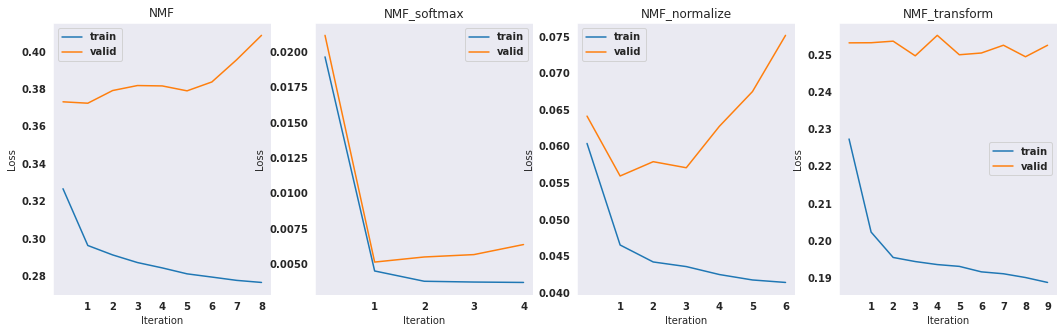
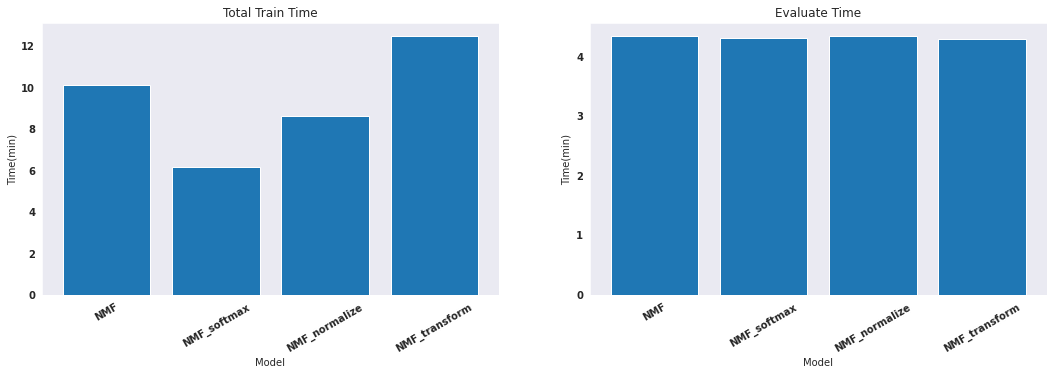
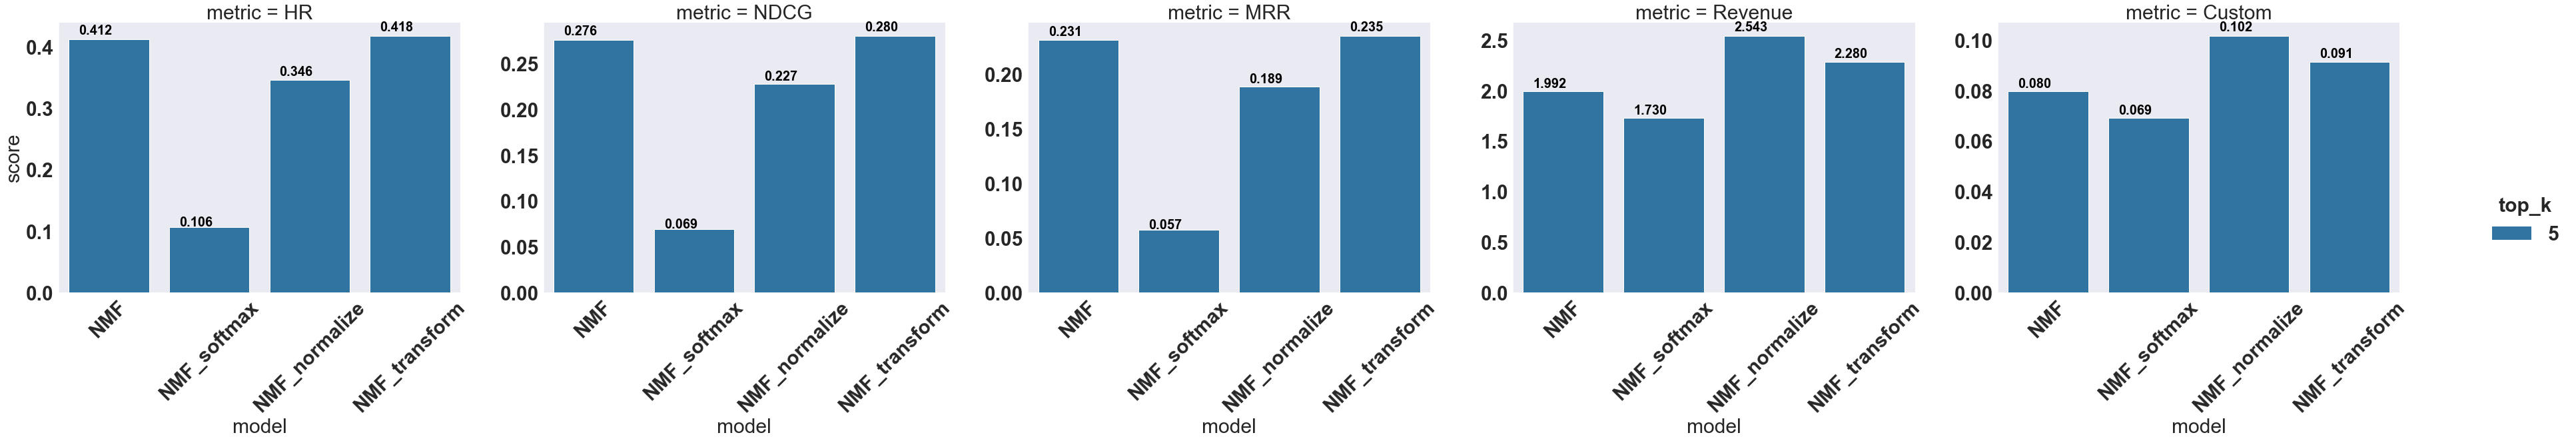



<br><br><br>
<br><br><br>
<br><br><br>

### NOTE:
    Due to computational power I trained for 10 epochs, and raised the batch to 256.
    Also, evaluate **only** when all epochs are done!
    
    I know this is not ideale! and we should eveluate after each epoch. but I had no choice!
    I timed all train & eval, and it takes a couple of hours to run it properly.
    I tried to use Colab , but it keeps on loging me out after some time.
    And my computer can't handle that(overheats and shutdown).   
    
    Also, if I would have evaluate the models after each epoch, I would use a line-plot, instead of a bar-plot.   
    In order to see how's the epoch improve(or not) each model's metric.   
    And I could see how it's effecting each metric simultaneously.
    
    
<br><br><br>
<br><br><br>
<br><br><br>

**Imports**

In [1]:
# General
import os  
import sys
import math
import time
import heapq
import argparse
import warnings
import multiprocessing

# Data Science
import numpy  as np
import scipy  as sp
import pandas as pd

# Visual
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Notebook
from IPython.display import display, HTML

# Deep
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Lambda,Activation
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate
from tensorflow.keras.callbacks import EarlyStopping


# Add Ons
import sklearn
import tensorflow_addons as tfa


<br>  

**Hide Warnings**

In [2]:
warnings.filterwarnings('ignore')

<br>

**Disable Autoscrolling**

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

<br>

**Set Directory**

In [4]:
data_dir = os.getcwd() + '/data/'
data_dir

'C:\\Users\\sahar\\DataScienceIDC\\RecSys\\Project/data/'

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Matrix Factorization with custom loss (35 points)
<br><br>

You work for an e-commerce company “Buy Here”.   
You are using the Matrix Factorization algorithm to recommend consumers with products which may be relevant to them using implicit feedback.   
The product manager tells you that he wants to improve the accuracy of the prediction model for more expensive products since these products are more profitable to the company.  


One of the common techniques to be more accurate for more expensive products is to give a higher weight in the loss function to more expensive products.   
You are using the Binary Cross Entropy loss function which is suitable for binary classification problems. 
Here is the custom loss function, when adding a weight to each instance in the training data, to give different weight for each sample.  


$L = -\frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( y_{i,j} log \bigg ( \sigma(\mu + p_i + o_j + u^{T}_{i}v_j) \bigg ) + \big ( 1-y_{i,j} \big ) log \bigg ( 1- \sigma \big ( \mu + p_i + o_j + u^{T}_{i}v_j \big ) \bigg ) \Bigg )$


- $𝛼_𝑗$ is the weight for instances which involve item j, 
- 𝜎(𝑧) = $\frac{1}{1+ 𝑒^{−𝑧}}$ is the logistic function
- 𝜇 is the global bias
- $𝑝_𝑖$ , $𝑜_𝑗$ are the user and item bias respectively 
- $𝒖_𝒊$ , $𝒗_𝒋$ are column vectors with size K, representing the latent weight vector of the user i and item j respectively 
- N is the number of instances in the training dataset.

<br><br><br>

**a. Derive the Gradient Decent update rule for the user and item latent vector weights as well as for
the global bias, user bias and item bias variables. Explain each step. (30 points)**


For convenience I'll `define` $z = \mu + p_i + o_j + u^{T}_{i}v_j $  and note `learning rate` with $\gamma$

<br><br>

Therefore:  
$L = -\frac{1}{N}\sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( y_{i,j} log \big ( \sigma(z) \big ) +  ( 1-y_{i,j} ) log \big ( 1- \sigma (z) \big ) \Bigg )$

<br><br>

Then:  
$  \frac{dL}{dz} =  $  
$  = \frac{-1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \frac{y_{i,j}}{\sigma(z)} \sigma '(z) - \frac{1-y_{i,j}}{1-\sigma(z)} \sigma'(z) \Bigg ) = $   
$  = \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \sigma '(z) \cdot \bigg ( \frac{1-y_{i,j}}{1-\sigma(z)} - \frac{y_{i,j}}{\sigma(z)} \bigg ) \Bigg ) =  $   
$  = \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \sigma(z) (1-\sigma(z)) \cdot \frac{dz}{d_{variable}} \cdot \bigg ( \frac{1-y_{i,j}}{1-\sigma(z)} - \frac{y_{i,j}}{\sigma(z)} \bigg ) \Bigg ) =  $  
$ =  \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \sigma(z)\big(1-\sigma(z)\big) \cdot \bigg ( \frac{1-y_{i,j}}{1-\sigma(z)} - \frac{y_{i,j}}{\sigma(z)} \bigg ) \cdot \frac{dz}{d_{variable}}  \Bigg )  = $  
$ =  \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \sigma(z)\big(1-\sigma(z)\big) \cdot  \bigg( \frac{\sigma(z)-y_{i,j}}{\sigma(z)\big(1-\sigma(z)\big)}  \bigg ) \cdot \frac{dz}{d_{variable}} \Bigg )  = $  
$ =  \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(z)-y_{i,j}  \big ) \cdot \frac{dz}{d_{variable}} \Bigg ) $  

<br><br>

**user latent** - Derive L by $𝒖_𝒊$ : 

by `Notation` : $\frac{dz}{du_i} = v_j$

Using the `chain rule`: $ \frac{dL}{du_i} = \frac{dL}{dz} \frac{dz}{du_i} =  \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(z)-y_{i,j}  \big ) \cdot \frac{dz}{du_i} \Bigg ) = \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(\mu + p_i + o_j + u^{T}_{i}v_j)-y_{i,j}  \big ) \cdot v_j \Bigg )$

gradient decent `update rule`:
$u_{ij} \Rightarrow u_{ij} + \gamma \Big (  \frac{dL}{du_i} \Big ), \forall i \in [1...k]$

<br><br>

**item latent** - Derive L by $𝒗_𝒋$ :

by `Notation` : $\frac{dz}{dv_j} = u_i$

Using the `chain rule`: $ \frac{dL}{dv_j} = \frac{dL}{dz} \frac{dz}{dv_j} =  \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(z)-y_{i,j}  \big ) \cdot \frac{dz}{dv_j} \Bigg ) = \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(\mu + p_i + o_j + u^{T}_{i}v_j)-y_{i,j}  \big ) \cdot u_i \Bigg )$

gradient decent `update rule`:
$v_{ij} \Rightarrow v_{ij} + \gamma \Big (  \frac{dL}{dv_j} \Big ), \forall j \in [1...k]$

<br><br>

**global bias** - Derive L by $\mu$ :

by `Notation` : $\frac{dz}{d\mu} = 1$

Using the `chain rule`: $ \frac{dL}{d\mu} = \frac{dL}{dz} \frac{dz}{d\mu} =  \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(z)-y_{i,j}  \big ) \cdot \frac{dz}{d\mu} \Bigg ) = \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(\mu + p_i + o_j + u^{T}_{i}v_j)-y_{i,j}  \big ) \cdot 1 \Bigg )$

gradient decent `update rule`:
$\mu \Rightarrow \mu + \gamma \Big (  \frac{dL}{d\mu} \Big )$

<br><br>

**user bias** - Derive L by $𝑝_𝑖$ :




by `Notation` : $\frac{dz}{d𝑝_𝑖} = 1$

Using the `chain rule`: $ \frac{dL}{d𝑝_𝑖} = \frac{dL}{dz} \frac{dz}{d𝑝_𝑖} =  \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(z)-y_{i,j}  \big ) \cdot \frac{dz}{d𝑝_𝑖} \Bigg ) = \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(\mu + p_i + o_j + u^{T}_{i}v_j)-y_{i,j}  \big ) \cdot 1 \Bigg )$

gradient decent `update rule`:
$𝑝_𝑖 \Rightarrow 𝑝_𝑖 + \gamma \Big (  \frac{dL}{d𝑝_𝑖} \Big ), \forall i \in [1...k]$

<br><br>

**item bias** - Derive L by $𝑜_𝑗$ :


by `Notation` : $\frac{dz}{d𝑜_𝑗} = 1$

Using the `chain rule`: $ \frac{dL}{d𝑜_𝑗} = \frac{dL}{dz} \frac{dz}{d𝑜_𝑗} =  \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(z)-y_{i,j}  \big ) \cdot \frac{dz}{d𝑜_𝑗} \Bigg ) = \frac{1}{N} \sum_{(i,j) \in S}^{N} \alpha_j \Bigg ( \big(\sigma(\mu + p_i + o_j + u^{T}_{i}v_j)-y_{i,j}  \big ) \cdot 1 \Bigg )$

gradient decent `update rule`:
$𝑜_𝑗 \Rightarrow 𝑜_𝑗 + \gamma \Big (  \frac{dL}{d𝑜_𝑗} \Big ), \forall j \in [1...k]$

<br><br>

<br><br>

**b. Given the prices of the different items from the catalog. How will you set the weights for each
training instance based on the item price. You can offer more than one alternative. Explain your
suggestion, and the advantage of each choice. (5 points)**

`Using Softmax: ` $W_i = Softmax\big({price}_i\big) = \frac{e^{{price}_i}}{\sum_{1}^{k} e^{{price}_i}}$

    Advantages: all values between zero to one,values in tain sum to one
    Disadvantages: very small values, inference
    Conclution: will not work well

`Using Normalization:` $W_i = Norm\big({price}_i\big) = \frac{{price}_i}{{price}_{max}} $

    Advantages: fast to compute, values in train between zero to one
    Disadvantages: outliers, inference for higher prices
    Conclution: might work well

`Using Sigmoid:` $W_i = Sigmoid\big({price}_i\big) = \frac{1}{1+e^{{price}_i}}$

    Advantages: fast to compute, all values between zero to one
    Disadvantages: most Weights will be very close to one
    Conclution: will not work well

`Using Z-scores & Sigmoid:` $W_i = Sigmoid\bigg(zscore\big({price}_i\big)\bigg) = Sigmoid\bigg(\frac{{price}_i - \mu}{\sigma} \bigg)$

    Advantages: all values between zero to one, no outliers
    Disadvantages: highly effected by the distribution of prices in train
    Conclution: might work well


`Using custom tranformation`: $\Bigg \{ W_i = \frac{{price}_i}{{price}_i+1} \Bigg \}$ or  $\Bigg \{ W_i = 1 - \frac{1}{{price}_i} \Bigg \}$  or $\Bigg \{ W_i = {\sigma}^\gamma\big({price}_i\big) = \frac{1}{ ( 1+e^{{price}_i} )^\gamma }, \gamma\in [0,1] \Bigg \}$
    
    Advantages: fast to compute, all values between zero to one
    Disadvantages: searching for the right function and params
    Conclution: will work well !




<br><br><br>
<br><br><br>
<br><br><br>

# Data Preperation

In [5]:
# Note: took this from the implementation Asi showed us

class Dataset(object):
    '''
    classdocs
    '''

    def __init__(self, path,file_train,file_test,file_test_neg):
        '''
        Constructor
        '''
        
        self.trainMatrix = self.load_rating_file_as_matrix(path + file_train)
        self.testRatings = self.load_rating_file_as_list(path + file_test)
        self.testNegatives = self.load_negative_file(path + file_test_neg)
        assert len(self.testRatings) == len(self.testNegatives)
        
        self.num_users, self.num_items = self.trainMatrix.get_shape()
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.sparse.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat
    
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    for (u, i) in train.keys():
        
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels


# Create train data
def get_train_data(train, epochs, num_negatives):
    inputs = []
    labels = []

    for _ in range(epochs):
        user_input, item_input, label = get_train_instances(train, num_negatives)
        inputs.append([np.array(user_input), np.array(item_input)])
        labels.append(np.array(label))
        
    return inputs,labels

In [6]:
data_dir = 'data/'
file_train    = 'ml-1m.train.rating.txt'
file_test     = 'ml-1m.test.rating.txt'
file_test_neg = 'ml-1m.test.negative.txt'

In [7]:
ratings = pd.read_csv(data_dir + file_train,
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])

Users = ratings['userid'].values
Movies = ratings['movieid'].values
Ratings = ratings['rating'].values
max_userid = ratings['userid'].drop_duplicates().max() + 1
max_movieid = ratings['movieid'].drop_duplicates().max() + 1

In [8]:
dataset = Dataset(data_dir,file_train,file_test,file_test_neg)

train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.get_shape()

print("Load data done - #user=%d, #item=%d, #train=%d, #test=%d"%(num_users, num_items, train.nnz, len(testRatings)))

Load data done - #user=6040, #item=3706, #train=994169, #test=6040


<br><br><br><br><br>
# Model Evaluation

In [9]:
# Note: took this from the implementation Asi showed us


# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None
_rnklist = None

def evaluate_model(model, testRatings, testNegatives, K):
    """
    Evaluate the performance of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs, mrrs, revs,cuss = [],[],[],[],[]
    
    # Single thread
    for idx in range(len(_testRatings)):
        (hr,ndcg,mrr,rev,cus) = eval_one_rating(idx)
        
        hits.append(hr)
        ndcgs.append(ndcg)  
        mrrs.append(mrr)    
        revs.append(rev)
        cuss.append(cus)
        
    return np.mean(hits), np.mean(ndcgs), np.mean(mrrs), np.mean(revs), np.mean(cuss)
    

def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict([users, np.array(items)], batch_size=batch_size, verbose=0)
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = list(predictions[i])
    items.pop()

    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    _rnklist = ranklist
    
    # metrics
    hr   = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    mrr  = getMRR(ranklist, gtItem)
    rev  = get_relevant_revenue(ranklist,gtItem)
    cus  = getProbaHitRatio(ranklist,gtItem)
    
    return (hr, ndcg, mrr, rev,cus)

<br><br>
**Metrics:**
- HitRatio
- NDCG
- MRR

In [10]:
# Note: took this from the implementation Asi showed us

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0
  
def getMRR(ranklist, gtItem):
    num_movies_tested = 0
    for item in ranklist:
        num_movies_tested += 1
        if item == gtItem:
            mrr = 1 / num_movies_tested
            return mrr
    return 0

<br>
save results:

In [11]:
learning_hist = {}
validing_hist = {}
learning_time = {}
evaluate_time = {}

result_columns = ['model', 'top_k','metric','score']

results = pd.DataFrame(columns = result_columns)
results

,model,top_k,metric,score


<br><br><br>
# Model Training

In [12]:
def model_train(model,inputs,labels,epochs,batch_size,top_k=5,just_eval=False,class_weights=None,sample_weight=None,patience=3):
    
    
    if not just_eval:
        # initial
        learning_hist[model.name] = []
        validing_hist[model.name] = []
        learning_time[model.name] = time.time()
        
        
        # train
        # I could use fit_gen but my data fits into memory, so I generated all data before hand
        for i in range(epochs):
            
            
            if class_weights != None:
                class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(labels[i]), labels[i])
                class_weights = {l:c for l,c in zip(np.unique(labels[i]), class_weights)}
  
            if sample_weight is 'softmax':            
                sample_weight = df_prices.loc[inputs[i][1],'Price']
                sample_weight = np.exp(sample_weight) / (  np.sum(np.exp(np.unique(sample_weight)))   )          
            elif sample_weight is 'normalize':
                sample_weight = df_prices.loc[inputs[i][1],'Price']
                sample_weight /= sample_weight.max()
            elif sample_weight is 'transform':
                sample_weight = df_prices.loc[inputs[i][1],'Price']
                sample_weight = sample_weight/(sample_weight+1)
            
            hist = model.fit(inputs[i], labels[i], batch_size=batch_size, epochs=1, verbose=1, shuffle=True,class_weight=class_weights,sample_weight=sample_weight,validation_split=0.2) # callbacks=[earlyStopping]
            learning_hist[model.name].extend(hist.history['loss'])
            validing_hist[model.name].extend(hist.history['val_loss'])
            
            # save the optimal model
            if len(validing_hist[model.name]):
                model.save_weights(model.name + '_weights.h5')
            elif hist.history['val_loss'] < np.min(validing_hist[model.name]):
                model.save_weights(model.name + '_weights.h5')
                
            # early stopping with patient
            if (len(validing_hist[model.name]) >= (patience+1)) and (sorted(validing_hist[model.name][-(patience+1):]) == validing_hist[model.name][-(patience+1):]):
                print('Activate: early stopping.')
                break
    
        # load optimal model
        model.load_weights(model.name + '_weights.h5')

        # loss & time
        learning_time[model.name] = (time.time()-learning_time[model.name])/60
        add_result(model.name,0,'TIME',learning_time[model.name])
        add_result(model.name,0,'LOSS',learning_hist[model.name])
    
    # eval
    evaluate_time[model.name] = time.time()
    add_eval(model,top_k)
    evaluate_time[model.name] = (time.time()-evaluate_time[model.name])/60
    
    

    

def add_eval(model,top_k):
    hr,ndcg,mrr,rev,cus = evaluate_model(model, testRatings, testNegatives, top_k)
    add_eval_result(model.name,top_k,hr,ndcg,mrr,rev,cus)

def add_eval_result(name,top_k,hr,ndcg,mrr,rev,cus):
    add_result(name,top_k,'HR',hr)
    add_result(name,top_k,'NDCG',ndcg)
    add_result(name,top_k,'MRR',mrr)
    add_result(name,top_k,'Revenue',rev)
    add_result(name,top_k,'Custom',cus)
    
def add_result(name,top_k,metric,score):
    global results
    results.loc[len(results)] = name, top_k ,metric,score

**Avoid Overfitting  - Regularization with early stopping**  
In machine learning, early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method.  
I wanted to use the buit-in `callback` method of `Keras` as follows:  
        
        EarlyStopping(monitor='val_loss', patience=3, mode='min',restore_best_weights=True)   
        *note: restore_best_weights=True - will save the best model*  

Although, due to the use of epoch=1, I implemented an early stopping by hand!  

<br>

Also, while stopping after `patience=_`, I used **Best model aproach** to load the optimal weights.  
As everybody knows, this is a logical action while training, and it's common to save the best preforming model on the validation set.  
Although, as I mentioned above, due to the use of epoch=1, I implemented a callback checkpoint by hand!    



<br><br><br>
<br><br><br>

## Question 2: Neural Collaborative filtering implementation (50 points)

<br><br>

For this question, you will use the <a href='https://drive.google.com/file/d/1-5o8Sg-hz4kU0-hBDjpXeWBpRl3AC1tv/view'>item_price.csv</a> file and the original dataset, implement and evaluate a
price sensitive recommender system

**a. Use the item_price.csv file to get the prices of each item. Explore the price distribution of items.
(5 points)**

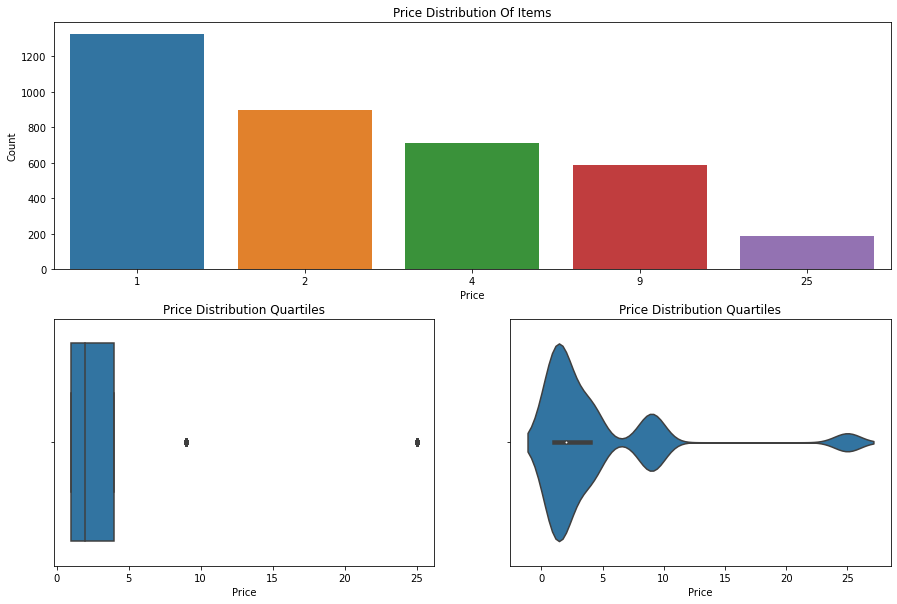

In [13]:
file_item_prices = 'item_price.csv'
df_prices = pd.read_csv(data_dir+file_item_prices,header=None,names=['Price'],index_col=0)

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
sns.countplot(x='Price', data=df_prices)
plt.title('Price Distribution Of Items')
plt.xlabel('Price')
plt.ylabel('Count')

plt.subplot(2,2,3)
sns.boxplot(x=df_prices,orient='h');
plt.title('Price Distribution Quartiles')
plt.xlabel('Price')


plt.subplot(2,2,4)
sns.violinplot(x=df_prices,orient='h');
plt.title('Price Distribution Quartiles')
plt.xlabel('Price')


plt.show();

As displayed in the plots, there are 5 different prices - 1,2,4,9,25  
Also, the lower the price, the more common it is.
<br><br><br>

<br><br>

**b. To evaluate the performance of the price sensitive model we will add another metric Revenue@K which will measure the overall revenue from the top 5 recommended hits. Implement the metric. (5 points)**

The function will be calculated as follows:  

    For each user: sum the prices of the top K recommended items which were rated as the revenue from the user.  
    Calculate the mean revenue from all users.


In [14]:
def getRevenue(ranklist,prices=df_prices,k=5):
    items_prices = prices.loc[ranklist]
    return items_prices.sum().values[0]

def get_relevant_revenue(ranklist, gtItem, prices=df_prices):
    revenue = 0
    if gtItem in ranklist:
        revenue = prices.loc[gtItem, "Price"]
    return revenue

<br><br>

**c. Suggest a metric of your own which will incorporate both the ranking of the recommended items as well as its price.   
Explain why this metric is suitable and demonstrate it as part of the evaluation in point e below. (10 points)**


I though I could do much better, and I tried to develope a new aproach using the nDCG formula to include the price.  
I call this method `Probability Normalized Discounted Cumulative Gain` - **P-nDCG** .  
This is based on a concept from <a href='https://medium.com/valassis-engineering-blog/p-ndcg-a-new-learning-to-rank-metric-for-large-lists-of-imbalanced-binary-data-4bee19dc4734'>a new learning-to-rank metric for large lists of imbalanced binary data</a>


If this is the original `nDCG`:  

$DCG_v \space \space = \sum_{i=1}^{v}  \frac{g(rel_i)}{log(i+1)}$  
$IDCG_v = \sum_{k \in REL_v} \frac{g(rel_k)}{log(k+1)}$  
$nDCG_v = \frac{DCG_v}{IDCG_v}$

<br>

This will be `P-nDCG`:  

<!-- % $DCG_v \space \space = \sum_{i=1}^{v} \Bigg( \frac{g(rel_i) \cdot Norm({price}_i) }{log(i+1)}  \Bigg)$  
% $IDCG_v = \sum_{k \in REL_v} \Bigg( \frac{g(rel_k) \cdot Norm({price}_k) }{log(k+1)}  \Bigg)$  
 -->

$P-DCG_v  = \sum_{i=1}^{v} \big( y_i^{est} {Price}_{i}^{est} \big) = \sum_{k\in REL_v} \big( y_k^{sorted} {Price}_{k}^{sorted}\big) $

$P-IDCG_v = \sum_{k \in REL_v}^{v} \big(y_k^{rel} {Price}_{k}^{rel} \big)$  

$P-nDCG_v = \frac{DCG_v}{IDCG_v}$

<br><br>
My idea is to optimize the implicit rating with the price. which is very similar to `nDCG` for the explicit ratings.  
Although in my version, I multiply it with the price, and use `Descending sort` due to the positive effect of high prices.  
I don't have to use the $Norm(Price)$, because nDCG use ranking, so it won't have an effect.

Probably due to my lack of math skills - it didn't work :))))  
But it was a nice idea...
<br><br><br><br>



So, I choose to go with a solution that is more simple and naive - some form of multiply the result of `HitRatio`/`MRR`/`nDCG` with some transformation of the price. For example:
- $HR * Norm\big({price}_i\big)$
- $MRR * Norm\big({price}_i\big)$  
- $nDCG * Norm\big({price}_i\big)$
- $etc.$


And I found that `HR` is a perfect match for that. I called this method `Proba-HitRatio`. 

$${ProbaHitRatio}_i = {HR}_i*\frac{{Price}_i}{{Price}_{max}} $$

In [15]:
MAX_PRICE = df_prices['Price'].max() 

def getProbaHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            norm_price = df_prices.loc[gtItem,'Price']/MAX_PRICE
            return norm_price
    return 0

<br><br>

**d. Select one of the models presented in the Neural Collaborative Filtering paper and incorporate the movie price to the loss function as part of training. (10 points)**

I will choose the **NeuroMatrixFactorization (NMF)**

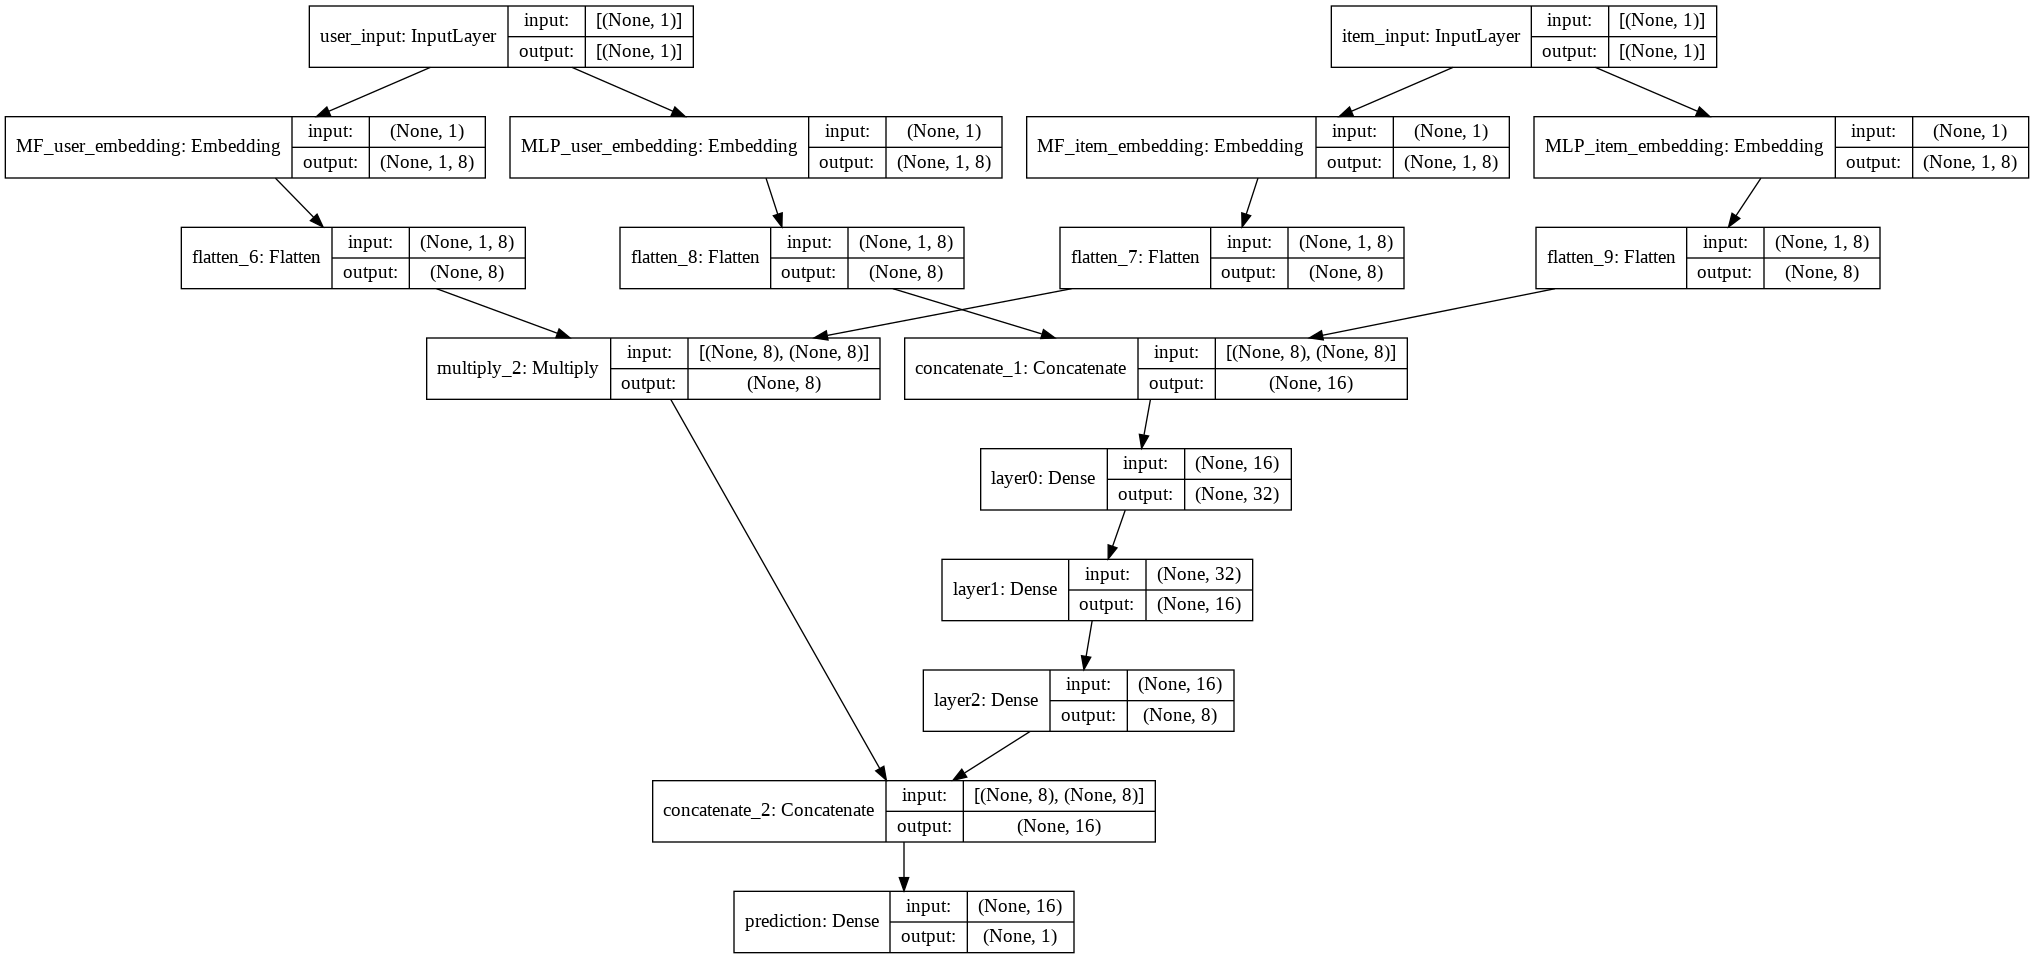

In [16]:
#Neural matrix factorization
def get_NMF_model(num_users, num_items, latent_dim_GMF, latent_dim_MLP, reg_GMF=[[0,0]],regs_MLP=[[0,0],0,0,0], layers=[32,16,8],name='NMF'):
    
    # quick sanity check
    assert len(layers) + 1 == len(regs_MLP), 'ERROR: regs != layers'
    
    #Number of layers in the MLP
    num_layer = len(layers) 

    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_GMF, name = 'MF_user_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_GMF, name = 'MF_item_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_MLP, name = 'MLP_user_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_MLP, name = 'MLP_item_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) 
    
    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    
    for idx in range(num_layer):
        layer =  Dense(layers[idx], kernel_regularizer = l2(regs_MLP[idx+1]), activation='tanh', name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)    
    model = Model(inputs=[user_input, item_input], outputs=prediction,name=name)
    
    return model

<br><br>
**HyperParams:**

In [17]:
# Note: some of these values are from the implementation Asi showed us

# sampling
num_negatives = 4

# dims
num_factors = 8
K_LATENT    = 20
hidden_dim  = 20

# metrics 
top_5k = 5
evaluation_threads = 1

# training 
do = 0.5
verbose = 1
epochs   = 10
batch_size = 256
learning_rate = 1e-2

**Visualization:**

In [18]:
def compare_curves():
    font = {'family' : 'DejaVu Sans',
            'weight' : 'bold',
            'size'   : 10}
    matplotlib.rc('font', **font)

    plt.figure(figsize=(18,5))

    for i,name in enumerate(learning_hist.keys()):
        plt.subplot(1,len(learning_hist),i+1)
        plt.plot(learning_hist[name],label='train')
        plt.plot(validing_hist[name],label='valid')
        plt.title(name)
        plt.xticks(np.arange(1, len(learning_hist[name]), 1.0))
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.legend();
    plt.show();
        
def compare_times():

    font = {'family' : 'DejaVu Sans',
            'weight' : 'bold',
            'size'   : 10}
    matplotlib.rc('font', **font);
    
    plt.figure(figsize=(18,5));

    plt.subplot(1,2,1)
    plt.bar(*zip(*learning_time.items()))
    plt.xticks(rotation=30)
    plt.title('Total Train Time')
    plt.xlabel('Model')
    plt.ylabel('Time(min)')

    plt.subplot(1,2,2)
    plt.bar(*zip(*evaluate_time.items()))
    plt.xticks(rotation=30)
    plt.title('Evaluate Time')
    plt.xlabel('Model')
    plt.ylabel('Time(min)')
    plt.show();    
    
    
    
def compare_metrics():
    font = {'family' : 'DejaVu Sans',
            'weight' : 'bold',
            'size'   : 30}

    matplotlib.rc('font', **font);
    sns.set_style("dark");

    g = sns.catplot(x="model", y="score",hue="top_k",col="metric",data=results[results.top_k!=0], kind="bar",col_wrap=5,height=7, aspect=1.5,ci=None,sharey=False);
    
    g.fig.subplots_adjust(top=1,right=0.93) ;
    for i in range(5):
        ax = g.facet_axis(0,i);    
        plt.xticks(rotation=45)
        for p in ax.patches:
            ax.text(p.get_x()+0.1, 
                    p.get_height() * 1.02, 
                   '{0:.3f}'.format(p.get_height()), 
                    color='black', 
                    rotation='horizontal', 
                    size='small',fontsize=20);

<br><br>

**e. Compare the results of the original model and the one with the customized loss across the four metrics: (20 points)** 

        - MRR@5
        - NDCG@5
        - Revenue@5 
        - your custom metric

create data for training:

In [19]:
inputs,labels = get_train_data(train,epochs,num_negatives)

<br>

#### NMF with BCE-Loss

In [20]:
model = get_NMF_model(num_users,num_items,num_factors,num_factors,name='NMF')
model.compile(optimizer = Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model,inputs,labels,epochs,batch_size)

15534/15534 [==============================] - 67s 4ms/step - loss: 0.2764 - val_loss: 0.4087
Activate: early stopping.


That's a good sign, that *early stopping* kicked in. That means that 10 epochs were too much, and it got to learn a lot from the initial epochs.
(This can also be just a coincidence, but I train this a number of time while coding this notebook, and it keeps on happaning, so it's all good)

If the "vanilla" model needs less then 10 epochs - most likely that the others will need *less/same number of epochs.*

Also, as I mentioned, I used a *best model aproach*, so I saved the best model, and will be using the optimal model from these various epochs.    

Due to the long training time, I was scared that I had to train this more them 10 epochs.  
So this is a **really awesome baseline for the training on later models.**
<br><br>


<br>

**NMF with Weighted-BCE-Loss**

Due to the ratio between the labels, there is an imbalanced between the labels (in my case: 4 to 1).  
I'll try `class_weights` to better optimize the model to the data.

`Weighted Binary Cross Entropy` is a nice base line to achieve that.

In [21]:
model = get_NMF_model(num_users,num_items,num_factors,num_factors,name='NMF_WBCE')
model.compile(optimizer = Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model,inputs,labels,epochs,batch_size,class_weights=True)

15534/15534 [==============================] - 72s 5ms/step - loss: 0.3717 - val_loss: 1.0830
Activate: early stopping.


<br><br><br>
The early stopping kicked in (which is great!) due to the validation loss raising.  
In former versions this is how it looked:
    
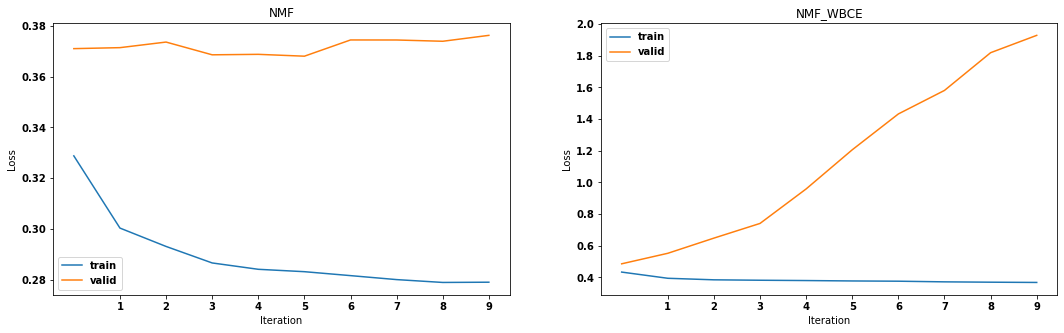


<br><br><br>
**Visulalize:**

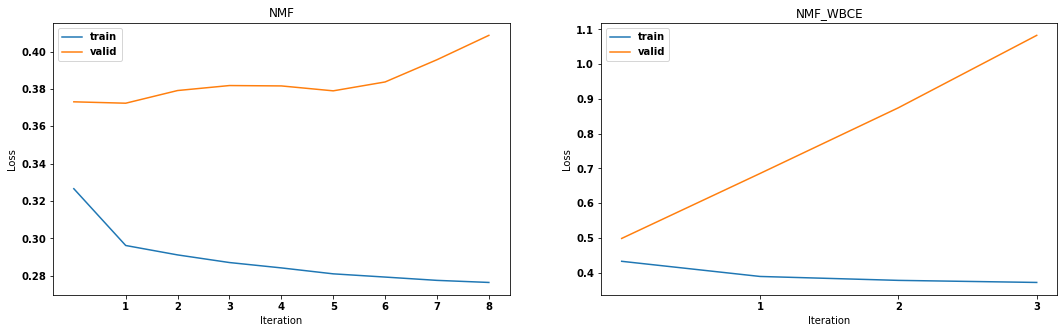

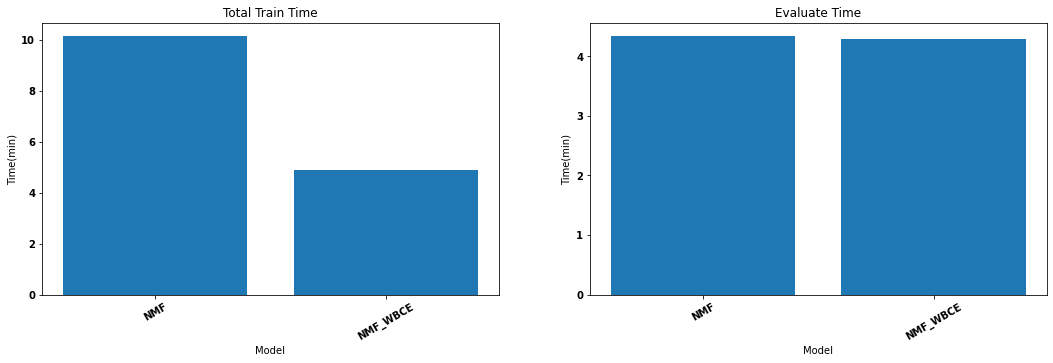

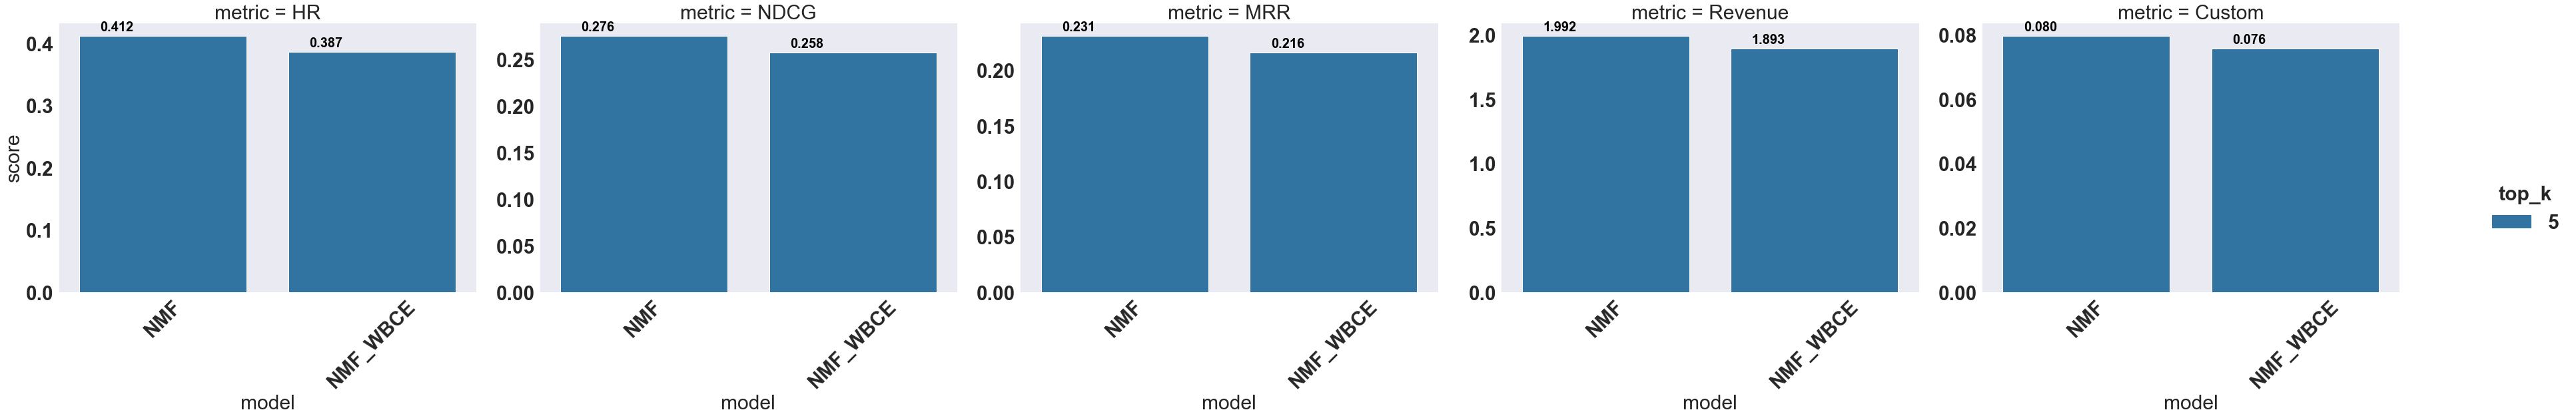

In [22]:
compare_curves();
compare_times();
compare_metrics();

<br><br><br>
Now that I know the best loss function is `BCE-Loss`, and I can use some **custom loss** values with other methods, and incorporate the price into the mix.  
Obviously, `W-BCE` has a lowwer training time, due to early stopping.


<br><br><br>
Drop the results of the `W-BCE Loss`:

In [23]:
results = results[results.model=='NMF']

del learning_hist['NMF_WBCE']
del learning_time['NMF_WBCE']
del validing_hist['NMF_WBCE']
del evaluate_time['NMF_WBCE']

<br><br><br>

<br>

- **Compare between different heuristics of item price to weights mapping.**

`NMF with BCE-Loss & Sample Weights`

As mentioned before, the items with a higher price worth more to the company.   
So, the items with the higher price will have a higher weight, while the items with a lower price will get a lower weight.  
This approach will give the loss function an edge. Meaning the loss for a high price item will be higher.  
Therefore, the model will be optimize to better predict high priced items.  

And for that I'll use `sample_weights`.  
As I mentioned, these weights are use for weighting the loss function durring training.

`Using Softmax: ` $W_i = Softmax\big({price}_i\big) = \frac{e^{{price}_i}}{\sum_{1}^{k} e^{{price}_i}}$

In [24]:
model = get_NMF_model(num_users,num_items,num_factors,num_factors,name='NMF_softmax')
model.compile(optimizer = Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model,inputs,labels,epochs,batch_size,sample_weight='softmax')

15534/15534 [==============================] - 73s 5ms/step - loss: 0.0037 - val_loss: 0.0064
Activate: early stopping.


`Using Normalization:` $W_i = Norm\big({price}_i\big) = \frac{{price}_i}{{price}_{max}} $

In [25]:
model = get_NMF_model(num_users,num_items,num_factors,num_factors,name='NMF_normalize')
model.compile(optimizer = Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model,inputs,labels,epochs,batch_size,sample_weight='normalize')

15534/15534 [==============================] - 73s 5ms/step - loss: 0.0414 - val_loss: 0.0751
Activate: early stopping.


`Using custom tranformation`: $ W_i = Transform\big(price_i\big) = \frac{{price}_i}{{price}_i+1} $

In [26]:
model = get_NMF_model(num_users,num_items,num_factors,num_factors,name='NMF_transform')
model.compile(optimizer = Adam(lr=learning_rate), loss='binary_crossentropy')
model_train(model,inputs,labels,epochs,batch_size,sample_weight='transform')

15534/15534 [==============================] - 78s 5ms/step - loss: 0.1887 - val_loss: 0.2526


<br>

- **Verify and present that the learning is ‘healthy’ (no overfitting, no under-fitting and that the results make sense).**

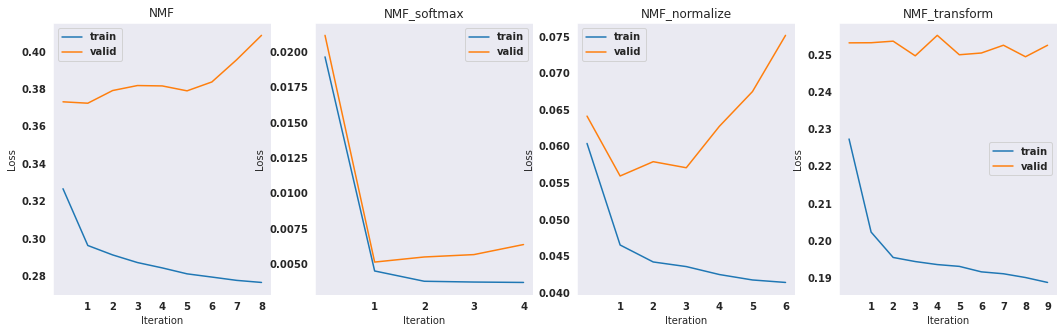

In [43]:
compare_curves();

`Here I can clearly see that:`  

- This is just great to see how a **small change** in the sample's weights has such a **huge impact** .  


- Some of the learning curves are use to be "unhealty", but early stopping put an end to that. This was clearly a good sign to use some form of regularization on the models.


- `NMF-Softmax` - In one epoch it manages to learn a lot(!), but after that got really overfit to the training set. An early stopping would be the best approch here. Also, the samples have a very small weights which lead to the very small loss values.


- `NMF` & `NFM_Transform` have the best curves. they manage to learn and optmize to the trainig set while keeping the validation somewhat better/same. 


<br><br>

<br>

- **Present the comparison results, discuss the results and the trade-offs and optimize.**

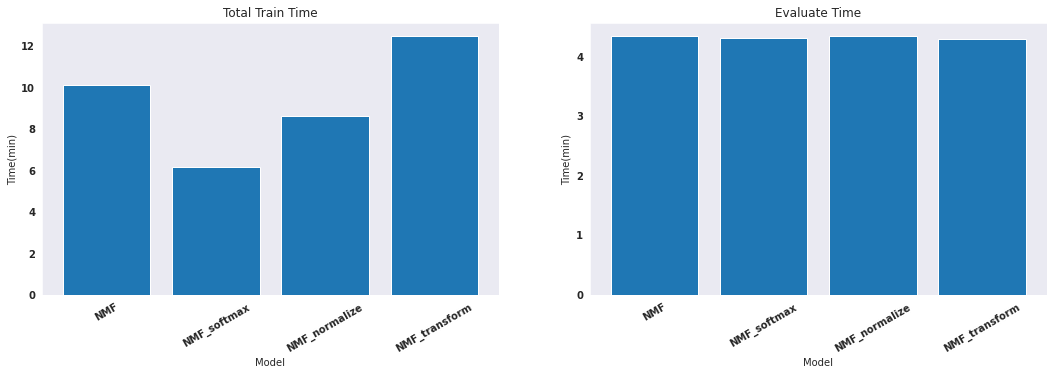

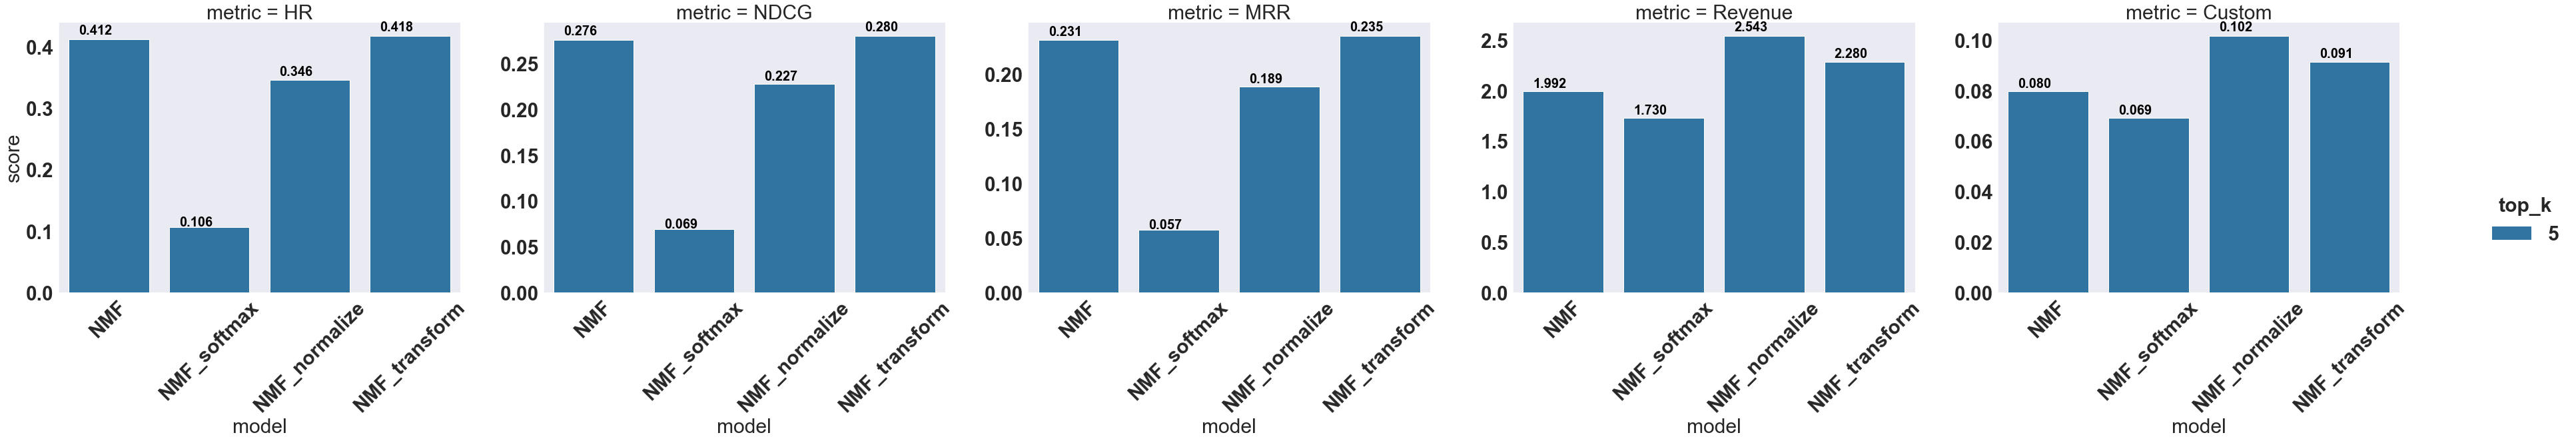

In [44]:
compare_times();
compare_metrics();

**Here I can clearly see that:**

- There is not actual difference when it comes to the train time or eval time. Which is great.  


- Choosing the best model is not a clear cut dessicion. Ech metric has it's own pros & cons.   
    *And choosing the right model based on the metrics, needs to be based on our buisness dession, use case and UI.
    For example, how many recommendations we show the user, is it a scrolling list, do we want to prefer income over UX,etc.*


- Based on these metrics, the `NMF_Normilize` has the highest revenue but still misses when it comes to pure recommendations.  
    
    *In my opinoin, I would choose `NMF` or `NMF Transform`, due to the goodness of the overall metrics.* 

<br><br>

`NMF Softmax model`  
This model performs bad, this is probably due to the quick overfit the trianing curve presented.  
The weight of each sample is very small so it **has a hard time optimize** and prefer the high prices. And I can see that through all the metrics.  


`NMF Normilize model`  
This model performs nicely. Which could be surprising due to the fact that it's kind of a *naive* approach (metric x price ratio).    
This model has two main advantages - one is explainability, and the second is the Revenue.  
The weight of each sample is normilize to **prefer high prices** .    


`NMF Transform model`  
This model has good performence. And is tie with `NMF` for the first place.  
I was very sceptical about this weighting approach , and was eager to try it out.    
I'm happy to see that an **unconventional weighting approach** for each sample (`sample_weight`) shows great results.   
This strengthens my hypothesis regarding different transformations (see above).


`NMF Model`  
This model has good performence. And is tie with `NMF_Transform` for the first place.  
Aperently the most naive and basic approach always does great compare to more sophisticated approaches.   
This reminds me the `MF` vs `Bias`, when the simple models - which are easy to explain and compute - have great results.


<br><br><br>
<br><br><br>
<br><br><br>

## Question 3: Hybrid recommender systems (15 points)

<br><br>

Cold start or users\items with a small number of interactions is a very common scenario in real world.   
In this question you will plan how you can leverage content based features to handle the cold start scenario. 

**a. Take a look at the original MovieLens 1M dataset.   
Which user and movie features could you use to enhance your recommender system and provide effective recommendations to users or items with a small number of ratings. (5 points)**

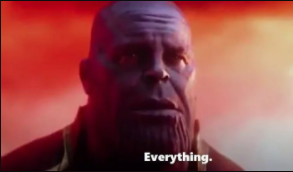

I can use **everything** in the MovieLens dataset, and let the Factorization Machine learn the importance of that feature.

<br><br>

From rating file: `UserID::MovieID::Rating::Timestamp`

- **Timestamp**  

    *I can use the timestamp to find a correlation between the time(e.g day of the week) a user rated a movie to a better recommendation.   
    For example, a person that likes a specific genre(e.g rommance) to watch in the weekend.*
    
    *Furthermore, there has to be some bias in a person's rating when comparing the time he rated the movie.  
    For example, on Sundays a person would rate movies higher then on Mondays.*
    
    *Another aspect could be some form of sequential watching, even Binge-watching, and watch "history".   
    A person who watch(rate) a batch of movie in a short amount of time, could leads us to believe that we should reccomend more binge-worthy movies.   
    Or recommend others to binge these movies if a lot of users doing so.  
    For example, people who watch the entire Die-Hard series.*

<br><br>

From users file: `UserID::Gender::Age::Occupation::Zip-code`

- **Gender**  
    *As every person knows, men and women like different types of movies. So I can asume there will be a big difference when looking on the genre of the movies.   
    For example, men are prune to like action movies compare to women.* 


- **Age**  
    *Different age groups prefer different type of genres. So I can asume there will be a big difference when looking on the genre of the movies.  
    For example, kids will like more cartoonish/Diseny films, while adults would prefer documantries, romance, etc.*


- **Occupation**  
    *Here I can use the same asumption that different occupations have different kind of genres to watch. but I can assume that there is a high correlation between the job you do and the lenght of the movies you watch.*


- **Zip-code**
    *The zip code will help me see the corrlation bewteen the place you are living to the movies you see. We can imagine the impact of location and the movie you see.   
    For example, french people would prune to watch movies created in France. Also, there is a higher probablity that a Japaneese person will like to see a Japaneese movie then a Russian one.*
    

<br><br>

From movie file: `MovieID::Title::Genres`

- **Genres**  
    *I already covered the use of the genres in HW3.*    


- **Title**
    *I can use the titles to better recommend the movies, due to the affect that a title will describe the movie in some semse. Also, any set of movies (e.g trilogy) will be using a similiar title.
    Another aspect is there might be a correlation between the movies a persons watching and the words that used in the title. A good example for that will be Science fiction, which will use words like Space, moon, super powers, etc. 
    Although the huge advantage of using the title works will be the Embbeddings, that will help us to understand the movie even better. For example, I mentioned Science fiction, but there is a varity of movies in this domain. The embbedings will incapsulate the sense of the movie, even inside the specific genre.*
    

    
    
    
    
    

This leads me to the next cool thing!
I can use the data in the `IMDB website` to get even more valuable data.
- **Movie Poster** (image)  
    *Use the poster of the movie and extract features/objects from it.*
    
    
- **Description**  
    *Use the text that describes/summarize the movie, with some NLP techniques (text2vec,entities, aggregate word-embeddings)*.
    
    
- **Cast**  
    *Use the cast - actors, derictors, etc - as an additinal featues.*
   
<br><br><br>
    
<u>Each element of the additinal data could help the Recsys to generalize better, find patterns, and to make sense of the data !</u>    

A simple example would be the `cold start problem`:   
- `New user` will have better recommendations due to having more initial data about the user (occupation,age,etc.)  
- `New movie` will be recommended due to having more initial data about the item (genre,title,cast,etc.)

<br><br><br><br>

**b. Describe a neural network based model to incorporate user or movie related features to the recommender system.   
Explain your suggestion. (there is no need to implement, provide pseudocode\visual). (5 points)**

This is the buety in the Factorization machines.  
I could add as many features I want, and it would know how to handle that.

For example, (while auxiliary features will be anything I want)
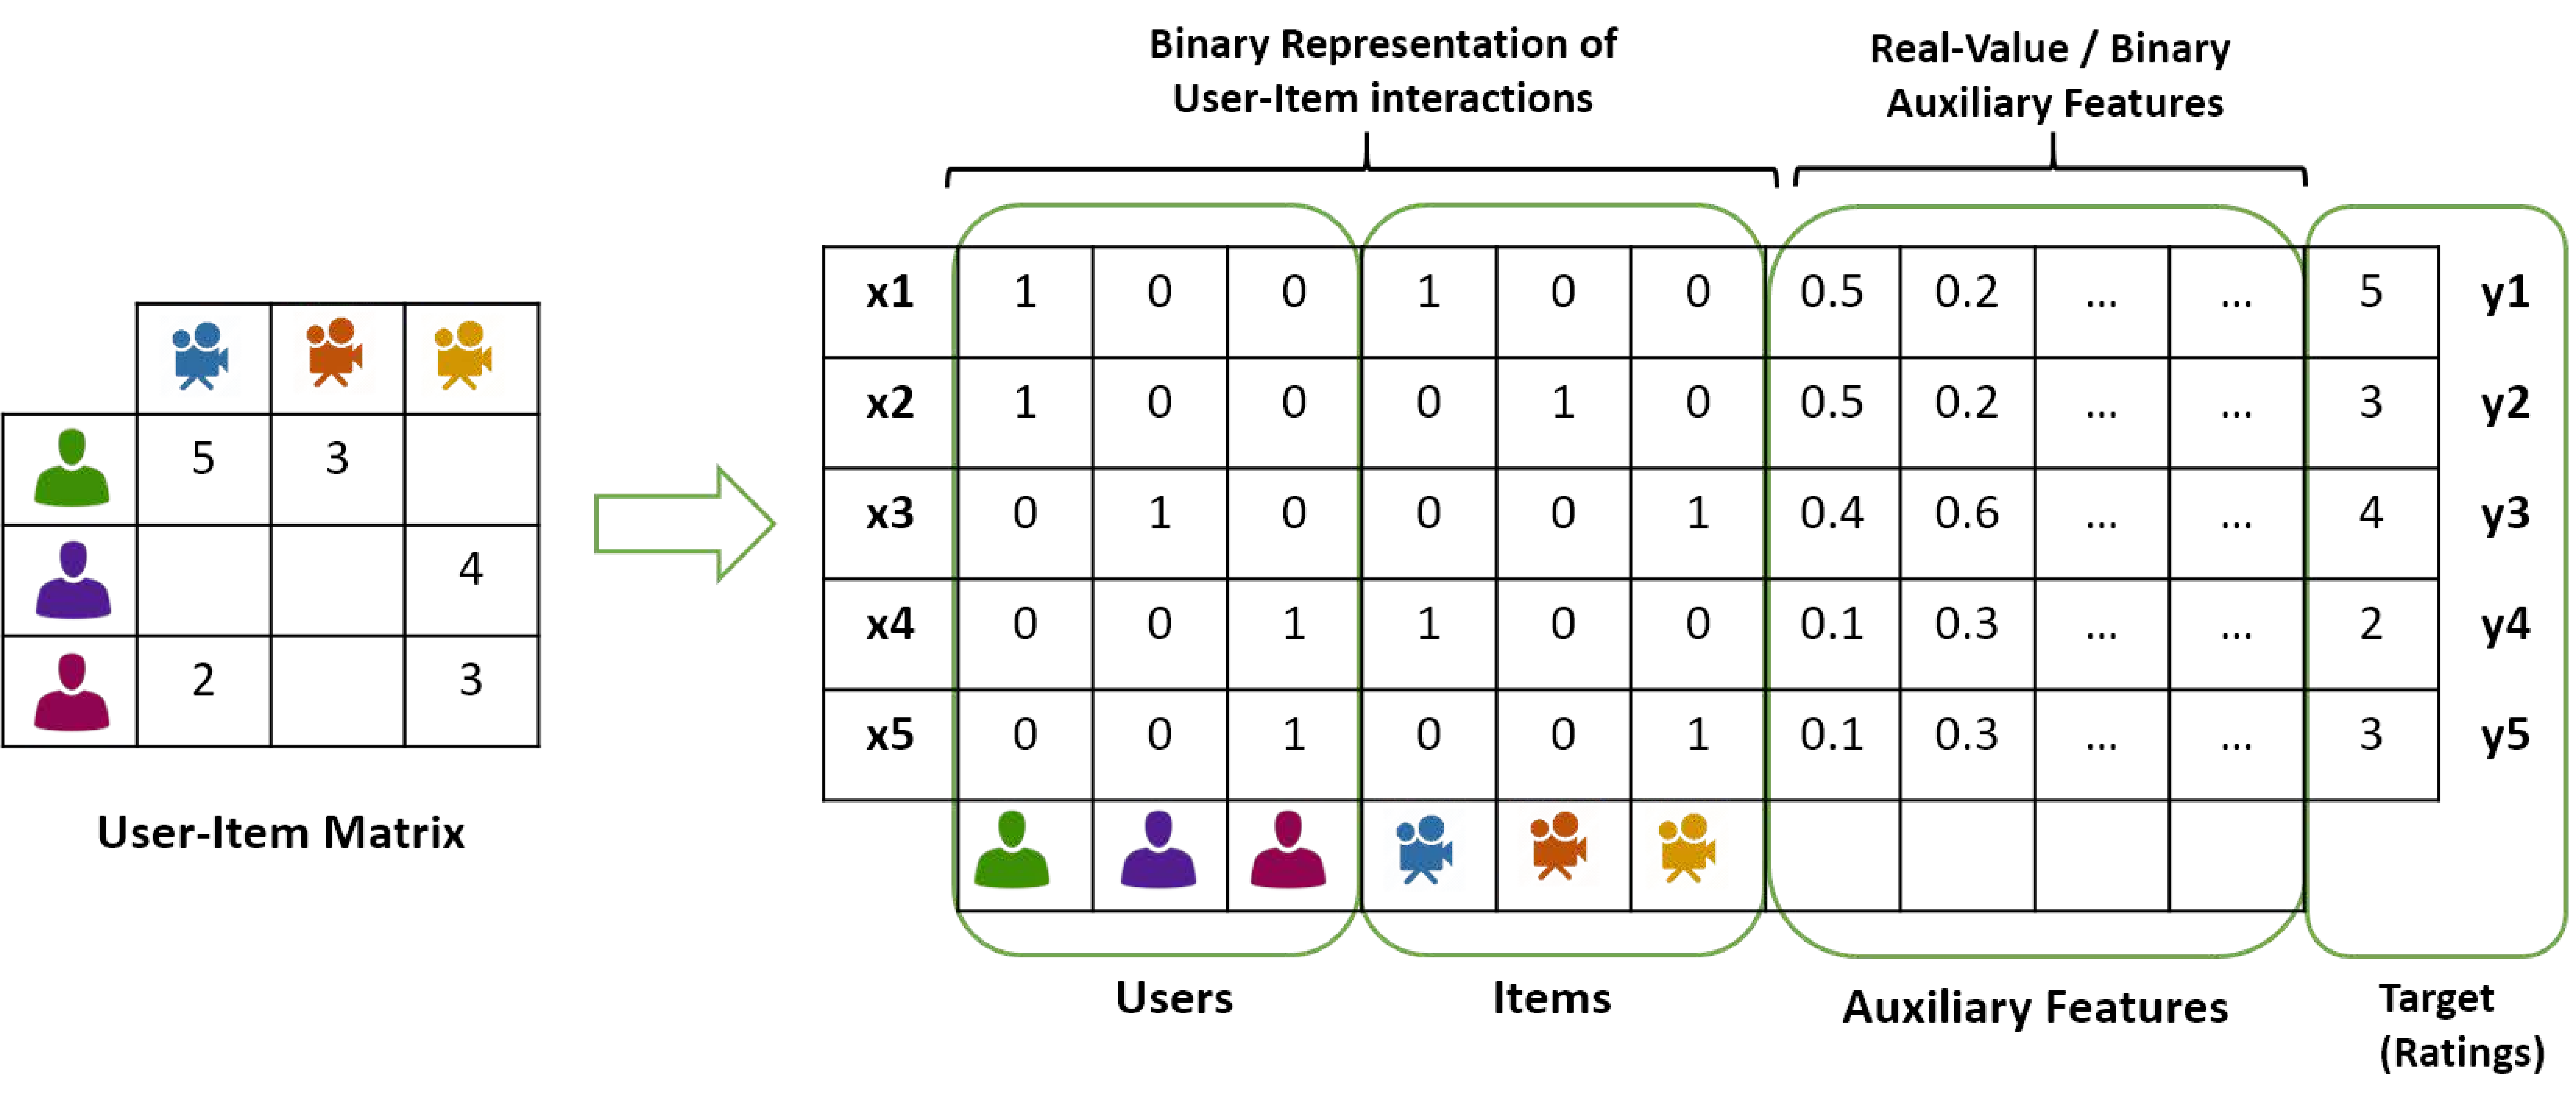


<br>

**And regarding the model:**


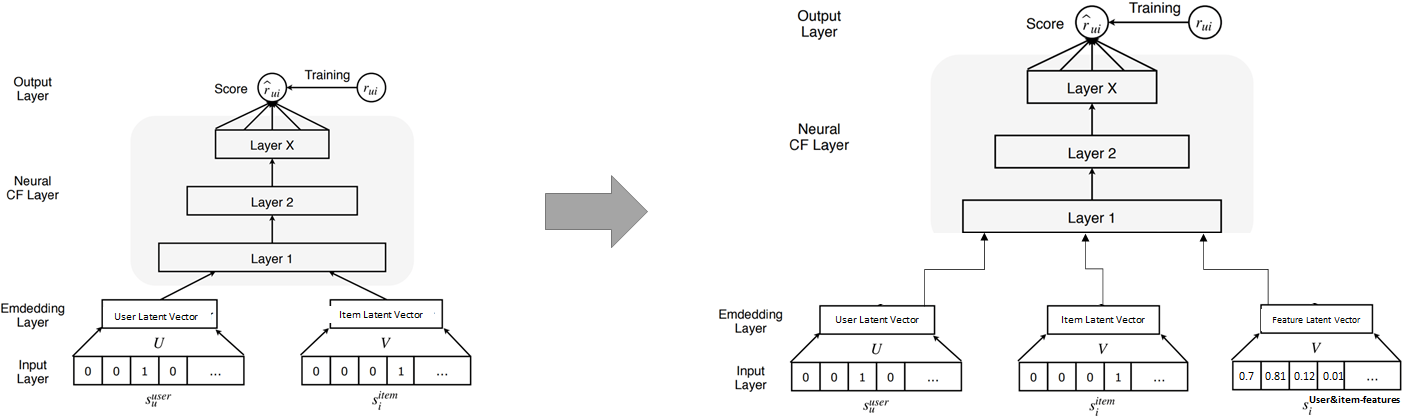


It's easy to see that any additinal feature information would be embedded into the `Feature Latent Vector`.  
This what makes the FM so awesome :) 

<br><br><br><br><br>

**c. How will you incorporate movie genres into the recommender system? How will you handle movies which belong to multiple genres?    
Explain the challenge and the proposed solution (there is no need to implement, provide pseudo-code). (5 points)**

As I mentioned above, the genres will be part of the additinal features (auxiliary features).

<br><br><br>

This issue was part of the HW3, and we also talked about this during class...

Regarding `multiple genres`, we can use a a binary vector to represent the genres that a movie has, just like in the `MovieLens` original dataset.

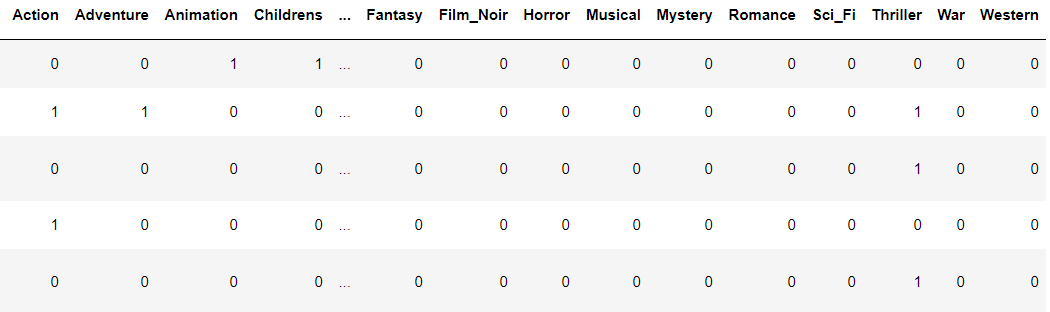

<br>

Another approach would be to use some sort of `frequency or TF-IDF` .      
But there is no need of using this, do the the effect of the `embedding layer`, that would already knows how to incapsulate that information in the best way to optimize our model.


<br><br><br><br>

**And regarding the model,** here is a generic example...

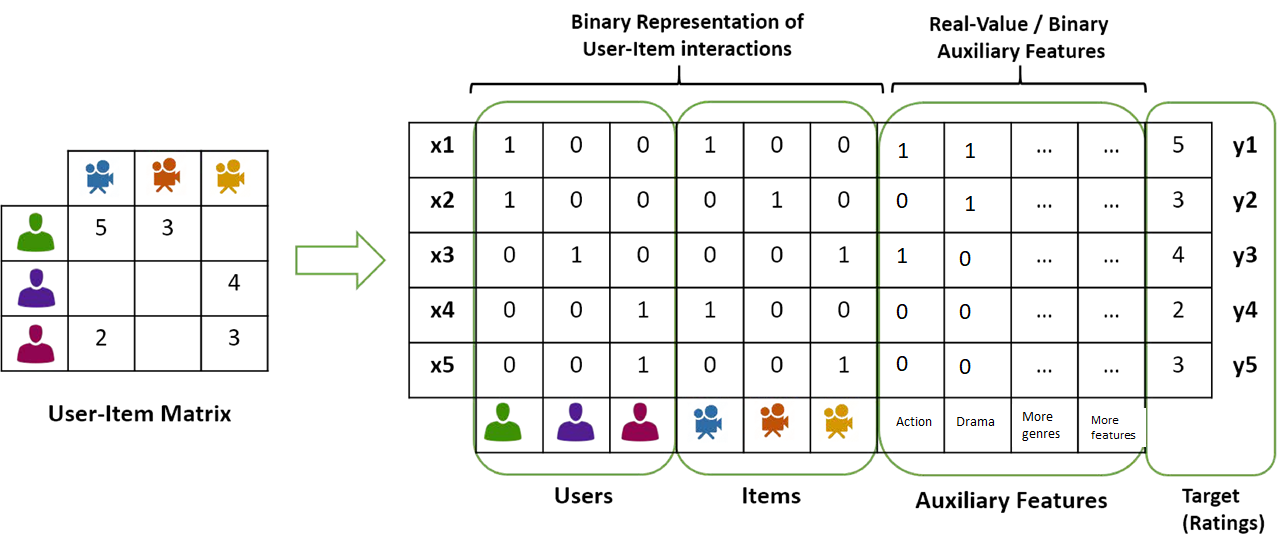


<br><br>
**It's easy to see how the genres added as an additinal features (e.g action, drama).**
- X1 row - the movie is Action & Drama
- X2 row - the movie is Drama
- X3 row - The movie is Action
- etc.

<br><br>



<br><br><br>
<br><br><br>
Please free to contact me if something is unclear...
# Thank you for reading this.  Sahar
<br><br><br>

<br><br><br>
<br><br><br>